In [ ]:
# run the script initnotebook.py in the cuurent folder
# Error when run multiple times becasue the directory changed
%run initnotebook.py

In [ ]:
import torch
from  torch.utils.data import DataLoader
import torch.nn as nn
from models.builder import EncoderDecoder as segmodel
from dataloader.cfg_defaults import get_cfg_defaults
from config_cityscapes import *
import os
from dataloader.cityscapes_dataloader import CityscapesDataset
from val_segformer_rgbonly import val_cityscape

import torch.nn.functional as F
from utils.visualize import unnormalize_img_numpy
import matplotlib.pyplot as plt

In [ ]:
from visualizer.visualizer import *

In [ ]:
output_dir = '/home/abjawad/Documents/GitHub/local-attention-model/visualizer/images'
if os.path.exists(output_dir):
    print('Output directory exists')

In [ ]:
# # # create a random image tensor of torch.Size([1, 64, 256, 256]) and save it
# img = torch.rand(1, 64, 256, 256)

# save_after_block(img, 'average', output_dir)

In [ ]:
config_path = 'dataloader/cityscapes_rgbd_config.yaml'
config_path = os.path.join(projectFolder, config_path)

cfg = get_cfg_defaults()
cfg.merge_from_file(config_path)
cfg.freeze()

data_mean = [0.291,  0.329,  0.291]
data_std = [0.190,  0.190,  0.185]

In [ ]:
cityscapes_test = CityscapesDataset(cfg, split='val')
test_loader = DataLoader(cityscapes_test, batch_size=1, shuffle=False, num_workers=4) # batchsize?
print(f'total test sample: {len(cityscapes_test)} v_iteration:{len(test_loader)}')


In [ ]:
pretrained_model_path = './pretrained/model_400.pth'
criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=config.background)

model = segmodel(cfg=config, criterion=criterion, norm_layer=nn.BatchNorm2d, test=True)
model = nn.DataParallel(model, device_ids = config.device_ids)
# model.to(f'cuda:{model.device_ids[0]}', non_blocking=True)

In [ ]:
saved_model_path = os.path.join(projectFolder, pretrained_model_path)
print(saved_model_path)
# exit()
state_dict = torch.load(saved_model_path)
model.load_state_dict(state_dict['model'], strict=False)
print(f'model loaded')
epoch = state_dict['epoch']


In [ ]:
# val_loss, val_mean_iou = val_cityscape(epoch, test_loader, model)

In [ ]:
def plot_output(img, gt, out):
    # Plot the input image (RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(img[0].permute(1, 2, 0).cpu().numpy())
    plt.title('Input Image')
    plt.show()

    # Plot the ground truth (GT)
    plt.figure(figsize=(5, 5))
    plt.imshow(gt[0].cpu().numpy(), cmap='viridis')
    plt.title('Ground Truth')
    plt.show()

    # Convert the output tensor to NumPy and plot the available output channels separately
    out = out[1].cpu().numpy()
    _, axes = plt.subplots(4, 5, figsize=(15, 12))

    # Loop through the 19 channels and plot them
    for i in range(19):
        row, col = divmod(i, 5)  # Calculate the row and column for each subplot
        ax = axes[row, col]  # Get the corresponding subplot
        channel_data = out[0, i, :, :]
        ax.imshow(channel_data, cmap='viridis')  # You can change the colormap as needed
        ax.set_title(f'Channel {i + 1}')  # Set a title for the subplot
    plt.tight_layout()
    plt.show()


model.eval()
with torch.no_grad():
    for idx, sample in enumerate(test_loader):
        imgs = sample['image']      #B, 3, 1024, 2048
        gts = sample['label']       #B, 1024, 2048
        imgs = imgs.to(f'cuda:{model.device_ids[0]}', non_blocking=True)
        gts = gts.to(f'cuda:{model.device_ids[0]}', non_blocking=True)

        img = imgs[:, :, :, :1024]
        gt = gts[:, :, :1024]
        loss, out, atten = model(img, gt, visualize=True, attention=True)
        print('loss = ', loss.shape)
        print('out = ', out.shape)
        print('atten = ', len(atten))
        # plot_output(img, gt, out)

        print(img.shape, gt.shape)
        # print(len(out), out[0].shape, out[1].shape)
        break

# tokenization:  torch.Size([1, 65536, 64])
# tokenization:  torch.Size([1, 16384, 128])
# tokenization:  torch.Size([1, 4096, 320])
# tokenization:  torch.Size([1, 1024, 512])

In [ ]:
print(img.shape)
print(len(atten))

In [167]:
import matplotlib.pyplot as plt


def get_attention_matrix(attention, layer, head):
    # sanity check
    layer = layer - 1
    head = head - 1
    if layer > len(attention):
        print('layer index out of range')
        return None
    if head > len(attention[layer]):
        print('head index out of range')
        return None
    atten = attention[layer][head]
    atten = atten.cpu().numpy()
    return atten


for i in range(1, len(atten)+1):
    for j in range(1, len(atten[i-1])+1):
        shape = get_attention_matrix(atten, i, j).shape
        if len(shape) == 4:
            atten[i-1][j-1] = atten[i-1][j-1].reshape(shape[1], shape[2], shape[3])
        print('attention layer', i, 'head ', j, atten[i-1][j-1].shape)


attention layer 1 head  1 torch.Size([256, 256, 256])
attention layer 1 head  2 torch.Size([1024, 64, 64])
attention layer 2 head  1 torch.Size([64, 256, 256])
attention layer 2 head  2 torch.Size([256, 64, 64])
attention layer 2 head  3 torch.Size([256, 64, 64])
attention layer 2 head  4 torch.Size([1024, 16, 16])
attention layer 3 head  1 torch.Size([256, 16, 16])
attention layer 3 head  2 torch.Size([256, 16, 16])
attention layer 3 head  3 torch.Size([1024, 4, 4])
attention layer 3 head  4 torch.Size([1024, 4, 4])
attention layer 3 head  5 torch.Size([1, 4096, 4096])
attention layer 4 head  1 torch.Size([256, 4, 4])
attention layer 4 head  2 torch.Size([256, 4, 4])
attention layer 4 head  3 torch.Size([256, 4, 4])
attention layer 4 head  4 torch.Size([256, 4, 4])
attention layer 4 head  5 torch.Size([1, 1024, 1024])
attention layer 4 head  6 torch.Size([1, 1024, 1024])
attention layer 4 head  7 torch.Size([1, 1024, 1024])
attention layer 4 head  8 torch.Size([1, 1024, 1024])


In [168]:
pixel = (300, 700)
layer = 4
head = 3

attention = get_attention_matrix(atten, layer, head)

factor = 4
downsample_factor = factor * 2**(layer - 1)

print("attention shape ", attention.shape, " attention arr type ", type(attention))

attention shape  (256, 4, 4)  attention arr type  <class 'numpy.ndarray'>


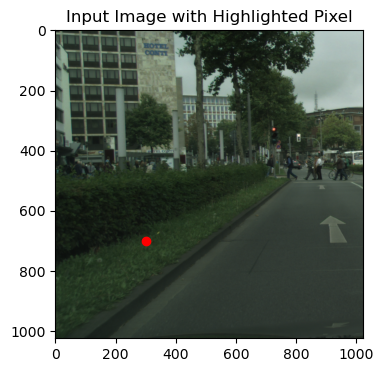

In [169]:
# Convert the tensor to a NumPy array
# image_array = image[0].permute(1, 2, 0).cpu().numpy()
unnormalized_image = unnormalize_img_numpy(img)
image_array = unnormalized_image

plt.figure(figsize=(4, 4))
plt.imshow(image_array)

# Highlight the pixel at (100, 100) in red
plt.scatter(pixel[0], pixel[1], c='red', marker='o')

plt.title('Input Image with Highlighted Pixel')
plt.show()

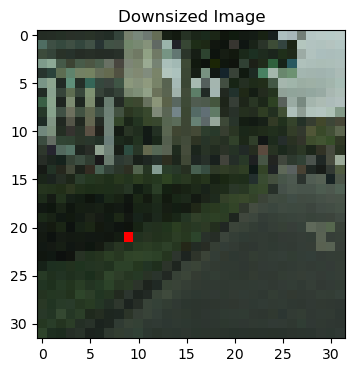

In [170]:
downsized_pixel = (pixel[0] // downsample_factor, pixel[1] // downsample_factor)

# downsize numpy image by downsample factor
downsized_array = unnormalized_image[::downsample_factor, ::downsample_factor]

# making image red at the pixel location
downsized_array[downsized_pixel[1], downsized_pixel[0]] = [255, 0, 0]

# Plot the downsized image
plt.figure(figsize=(4, 4))
plt.imshow(downsized_array)

plt.title('Downsized Image')
plt.show()

In [171]:
print('attention shape ', attention.shape)
patch_size = np.sqrt(attention.shape[1]).astype(int)
print('patch size ', patch_size)

print("downsized array shape ", downsized_array.shape)

attention shape  (256, 4, 4)
patch size  2
downsized array shape  (32, 32, 3)


In [172]:
import numpy as np

# Define the downsized array
array_shape = downsized_array.shape

# Calculate the number of rows and columns for patches
num_rows = array_shape[0] // patch_size
num_cols = array_shape[1] // patch_size

# Create an empty list to store the patches
patches = []

# Iterate through the array and extract patches
for i in range(num_rows):
    for j in range(num_cols):
        row_start = i * patch_size
        row_end = (i + 1) * patch_size
        col_start = j * patch_size
        col_end = (j + 1) * patch_size
        patch = downsized_array[row_start:row_end, col_start:col_end]
        patches.append(patch)

print('Number of patches = ', len(patches))

Number of patches =  256


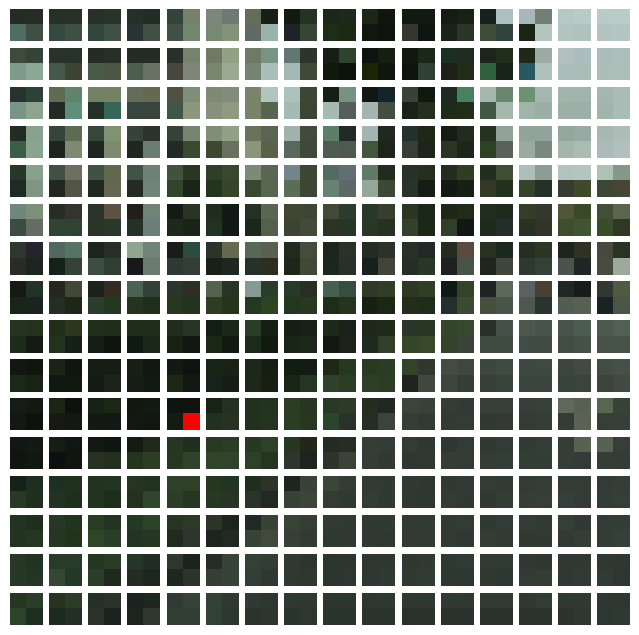

In [173]:
# Create a single plot for all patches
fig, axarr = plt.subplots(num_rows, num_cols, figsize=(8, 8))

for i in range(num_rows):
    for j in range(num_cols):
        axarr[i, j].imshow(patches[i * num_cols + j])
        axarr[i, j].axis('off')

plt.show()

Patch row =  10
Patch column =  4
Patch index =  164


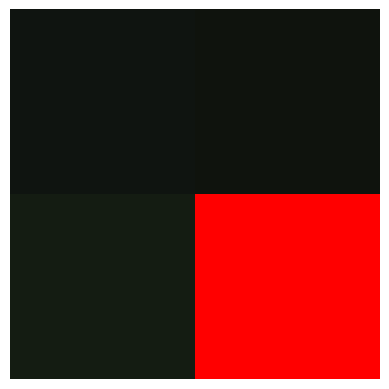

In [174]:
# find the patch that contains the pixel

# Calculate the row and column of the patch that contains the pixel
patch_row = downsized_pixel[1] // patch_size
patch_col = downsized_pixel[0] // patch_size

print('Patch row = ', patch_row)
print('Patch column = ', patch_col)

patch_idx = patch_row * num_cols + patch_col

print('Patch index = ', patch_idx)

# Plot the patch that contains the pixel
plt.imshow(patches[patch_idx])
plt.axis('off')
plt.show()

In [175]:
pixel_inside_patch = (((pixel[0] // downsample_factor) % patch_size), 
                      ((pixel[1] // downsample_factor) % patch_size))

print('Pixel inside patch = ', pixel_inside_patch)

pixel_idx_inside_patch = pixel_inside_patch[1] * patch_size + pixel_inside_patch[0]

print('Pixel index inside patch = ', pixel_idx_inside_patch)
print(patches[patch_idx][pixel_idx_inside_patch//patch_size, pixel_idx_inside_patch%patch_size])

Pixel inside patch =  (1, 1)
Pixel index inside patch =  3
[255   0   0]


(256, 4, 4)
Attention patch shape =  (4, 4)
Attention for the pixel =  (4,)
Attention for the pixel =  (2, 2)


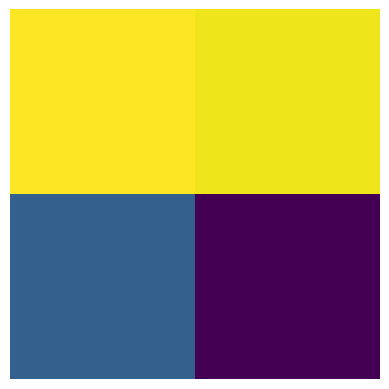

In [176]:
print(attention.shape)

# Get the attention for the patch that contains the pixel
attention_patch = attention[patch_idx]

print('Attention patch shape = ', attention_patch.shape)

attention_pixel = attention_patch[pixel_idx_inside_patch]

print('Attention for the pixel = ', attention_pixel.shape)

# reshape to 2d with patch_size x patch_size
attention_pixel = attention_pixel.reshape(patch_size, patch_size)

print('Attention for the pixel = ', attention_pixel.shape)

# Plot the attention
plt.imshow(attention_pixel)
plt.axis('off')
plt.show()

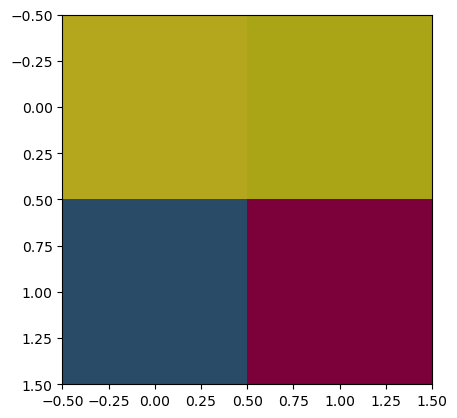

In [185]:
# plot attention_pixel (16, 16) over the patch (16, 16, 3)
patch_with_pixel = patches[patch_idx].copy()
plt.imshow(patch_with_pixel)
plt.imshow(attention_pixel, alpha=0.7, cmap='viridis')
plt.show()

In [199]:
# target size (256, 256)
# rescale img to target size

print(unnormalized_image.shape)

# rescale the image to target size
target_size = (256, 256)
rescaled_image = cv2.resize(unnormalized_image, target_size)
print(rescaled_image.shape)

print(attention.shape)
print(downsample_factor//factor)

attention_upsample_fact = 2**(layer - 1)
print(attention_upsample_fact)

new_dimentation = (attention.shape[1] * attention_upsample_fact, attention.shape[2] * attention_upsample_fact)
print(new_dimentation)

attention_pixel_upsampled = cv2.resize(attention_pixel, new_dimentation)
print(attention_pixel_upsampled.shape)

patch_start = (patch_idx // , patch_idx % attention_upsample_fact)
print(patch_start)
# plt.imshow(attention_pixel_upsampled)
# plt.show()


(1024, 1024, 3)
(256, 256, 3)
(256, 4, 4)
8
8
(32, 32)
(32, 32)
(20, 4)


In [178]:
# # Create an empty three-channel array
# atten_for_pixel_rgb = np.zeros((16, 16, 3))

# # Copy the single-channel data into each channel
# atten_for_pixel_rgb[:, :, 0] = attention_pixel
# # atten_for_pixel_rgb[:, :, 1] = atten_for_pixel
# # atten_for_pixel_rgb[:, :, 2] = atten_for_pixel

# # normalize by mean and std
# atten_for_pixel_rgb = (atten_for_pixel_rgb - np.mean(atten_for_pixel_rgb)) / np.std(atten_for_pixel_rgb)

# print('atten for pixel rgb', atten_for_pixel_rgb.shape)
# # plot the attention matrix
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('Attention Matrix')
# ax.imshow(atten_for_pixel_rgb)
# plt.show()